# Binary Classification
This notebook will approach the popularity prediction task as a binary classification problem. The videos will either be classified as viral or non-viral

In [1]:
%cd ..

C:\Users\georg\Documents\msc-project


In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import neighbors, svm, linear_model,dummy,ensemble
from sklearn.metrics import make_scorer, precision_score, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from src.evaluation import compare_models
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("data/processed/tracks.csv")

The threshold chosen for the viral videos will be 1e+06, as most videos seem to be below this threshold.

<AxesSubplot:ylabel='View count'>

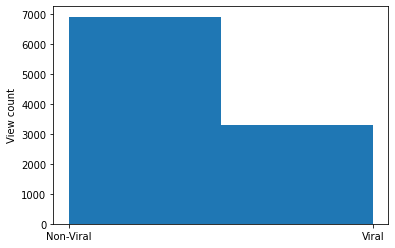

In [19]:
viral_threshold = 1e+06
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms',
    'popularity'
]

def get_data_for_threshold(threshold):
    views = df['views']
    data = df.loc[:,features]
    targets = views.apply(np.digitize,bins=[0,threshold,views.max() +1])

    return data, targets

data, targets = get_data_for_threshold(viral_threshold)
plt.xticks([1,2],["Non-Viral","Viral"])
plt.ylabel("View count")
targets.hist(bins=2, grid=False)

## Model Comparison
Similar to the multiclass classification task, multiple models are evaluated and compared

In [23]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]

oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': 'recall_macro',
    'accuracy': 'accuracy'
}
compare_models(oversampled_models, metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_accuracy
0,Baseline,0.743018,0.004365,0.490593,0.489241,0.494660
1,5-KNN,0.776737,0.534776,0.527154,0.531066,0.525522
2,10-KNN,0.787553,0.590329,0.533459,0.537597,0.555989
3,SVM Linear,7.129192,0.433409,0.577899,0.586305,0.544723
4,SVM RBF,5.976191,1.811489,0.575006,0.585630,0.582834
5,Random Forest,3.198795,0.054854,0.551736,0.548719,0.617223
6,Logistic Regression,0.733083,0.003774,0.581632,0.593212,0.577543


Random forest appears to outperform the rest of the models in terms of accuracy, as in the multiclass attempt. Logistic regression on the other hand performs better in terms of precision and recall.

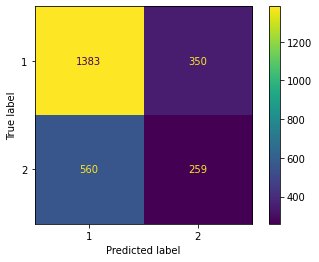

In [6]:
X_train, X_test, y_train,y_test = train_test_split(data, targets, random_state=1)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = ensemble.RandomForestClassifier()
model.fit(X_train,y_train)
predicted = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,predicted)

By examining the confusion matrix of the Random Forest Classifier we see that the non-popular class had the most true positives, while a lot of the datapoint of the popular class were also classified as non-popular. This seems to be due to the class imbalance even after synthetic resampling.

## Model Optimization
We further optimize the Logistic Regression model by performing a grid search over its hyperparameter space

In [7]:
train_X, test_X, train_y, test_y = train_test_split(data, targets, random_state=1)
model = Pipeline([
    ('std',StandardScaler()),
    ('lr',linear_model.LogisticRegression())
])

params = [
    {
        'lr__penalty':['l1','l2'],
        'lr__C':[0.1,1,10],
        'lr__class_weight':['balanced'],
        'lr__solver':['saga'],
        'lr__random_state':[1],
    },
    {
        'lr__penalty':['none'],
        'lr__class_weight':['balanced'],
        'lr__solver':['saga'],
        'lr__random_state':[1],
    },
    {
        'lr__penalty':['elasticnet'],
        'lr__l1_ratio':[0.01,0.1,1],
        'lr__C':[0.1,1,10],
        'lr__class_weight':['balanced'],
        'lr__solver':['saga'],
        'lr__random_state':[1],
    }
]
optimizer = GridSearchCV(model, params,scoring='precision_macro')
optimizer.fit(train_X,train_y)

GridSearchCV(estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'lr__C': [0.1, 1, 10],
                          'lr__class_weight': ['balanced'],
                          'lr__penalty': ['l1', 'l2'], 'lr__random_state': [1],
                          'lr__solver': ['saga']},
                         {'lr__class_weight': ['balanced'],
                          'lr__penalty': ['none'], 'lr__random_state': [1],
                          'lr__solver': ['saga']},
                         {'lr__C': [0.1, 1, 10],
                          'lr__class_weight': ['balanced'],
                          'lr__l1_ratio': [0.01, 0.1, 1],
                          'lr__penalty': ['elasticnet'],
                          'lr__random_state': [1], 'lr__solver': ['saga']}],
             scoring='precision_macro')

In [8]:
optimizer.best_params_

{'lr__C': 1,
 'lr__class_weight': 'balanced',
 'lr__penalty': 'l2',
 'lr__random_state': 1,
 'lr__solver': 'saga'}

In [9]:
optimizer.score(test_X,test_y)

0.581537961703251

Hyperparameter optimization achieved a slight improvement in precision, now further optimization will be performed using AdaBoost

In [45]:
base = linear_model.LogisticRegression(C=1.0,class_weight='balanced',penalty='l2',random_state=1,solver='saga')
boosted = ensemble.AdaBoostClassifier(
    base_estimator = base,
    random_state=1,
    n_estimators=100
)
boosted.fit(train_X,train_y)

c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\

c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\

c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\users\georg\documents\

AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                     random_state=1,
                                                     solver='saga'),
                   n_estimators=100, random_state=1)

In [46]:
boosted.score(test_X,test_y)

c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


0.6790752351097179

c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


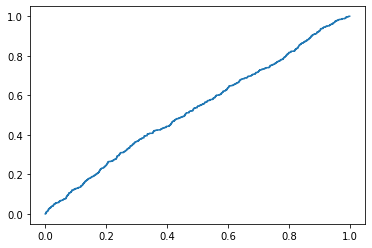

In [47]:
probabilities = boosted.predict_proba(test_X)
fpr, tpr, thresholds = roc_curve(test_y - 1, probabilities[:,1])
plt.plot(fpr, tpr)